In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cycler
import numpy as np
import polyan
from polan import find_poly_peaks,fit_peaks

<h1>Tabulating main peaks for individual transcripts</h1>

In [2]:
#read in list of datasets to be processed and context information (length) for genes
Datasets_table = pd.read_csv('Data/yeast_datasets.csv')
genes = pd.read_csv('Data/sacCer3 genes.csv')[['name','length']]; genes.columns = ['ORF','length']
RNA_dats = pd.read_csv('Data/RNA_reference.csv')
#define datasets that do not yield well-formed profiles when modelled with the reference dataset
exclude_set = ['GSE121189','108778','115366','56622','100626']
Datasets = [d for d in Datasets_table['SeriesID'] if not d in exclude_set]
#prepare a dataframe to receive the results
loads = pd.DataFrame({'ORF':genes['ORF']})
#process each dataset file listed in the Datasets table
for Dataset in Datasets:
    #read in dataset
    dats = pd.read_csv("Data/" + Dataset + '.csv')[['ORF','Ribo_Prints']]
    #add reference RNA data 
    dats=dats.merge(RNA_dats, how='inner',on='ORF')
    #remove all datapoints where RNA = 0 to avoid dividing by zero
    dats = dats.loc[dats['RNA_Prints'] > 0]
    #add information on gene lengths to enable calculation of RPK values
    dats = dats.merge(genes, how='inner',on='ORF')
    #calculate conversion factors from RNA RPK / Ribo Prints to numbers of RNAs / Ribosomes
    RNA_Conv = 60000 / (dats['RNA_Prints']/dats['length']/1000).sum()
    Ribo_Conv = 170000 / dats['Ribo_Prints'].sum()
    #calculate ribosome loads
    dats[Dataset] = round((dats['Ribo_Prints'] * Ribo_Conv) / ((dats['RNA_Prints'] / dats['length']/1000)*RNA_Conv))
    #discard unnecessary columns
    dats = dats[['ORF',Dataset]]
    #merge data for this dataset into the main table
    loads = loads.merge(dats, how='left',on='ORF')
    loads = loads.fillna(0)
#add RNA abundance and length data into the table
RNA_ref = RNA_dats.merge(genes, how='inner',on='ORF')
RNA_Conv = 60000 / (RNA_ref['RNA_Prints']/RNA_ref['length']/1000).sum()
RNA_ref['copies'] = ((RNA_ref['RNA_Prints'] / RNA_ref['length']/1000)*RNA_Conv)
loads = loads.merge(RNA_ref, how='inner',on='ORF')

<h2>Display main peak positions for selected individual RNAs</h2>
<ul>
    <li>YDL184C: RPL41 - short</li>
    <li>YOR303W: BOL3 - short</li>
    <li>YEL009C: GCN4 - translationally repressed</li>
    <li>YOR128C: ADE2 - household gene</li>
    <li>YOL086C: ADH1 - household gene</li>
    <li>YFL039C: ACT1 - household gene</li>
</ul>

In [3]:
#define list of selected examples
selec = ['YDL184C','YOR303W','YOR128C','YOL086C','YFL039C','YEL009C']
selec_common = ['RPL41','BOL3','ADE2','ADH1','ACT1','GCN4']

#read in the experimental profile to display as reference
yeast_trace = pd.read_csv('Data/poly_yeast.csv')
#ensure that data are in ascending x axis order
yeast_trace = yeast_trace.sort_values('x')
#normalise x axis 
yeast_trace.x = yeast_trace.x / max(yeast_trace.x)
#define peak locations as in figure 3
autopeaks = np.asarray(find_poly_peaks(yeast_trace))
extrapeaks,peakfun = fit_peaks(autopeaks,0.95,mode=0.34)
peak_locs = list(autopeaks) + list(extrapeaks)

In [4]:
rowcount = 0
xs,ys = [],[]
for gene in selec:
    #select the data for the selected gene
    peaks = loads.loc[loads['ORF'] == gene].values[0,1:-3]
    #convert peak numbers higher than the modelled range to the top of the modelled range
    peaks = [n if n <= 14 else 14 for n in peaks]
    peaks = [1 if peak == 0 else peak for peak in peaks]
    #convert peak numbers to x coordinates and record
    x = ([peak_locs[int(i+1)] + np.random.randn() * peak_locs[int(i)] * 0.01 for i in peaks])
    xs.append(x)
    y = [1.1 + (rowcount * 0.5)]*len(xs[-1])
    y = [this_y + np.random.randn() * 0.04 for this_y in y]
    ys.append(y)
    rowcount += 1

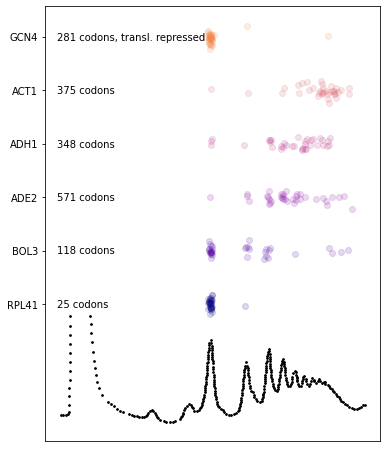

In [5]:
n = len(xs) + 2
color = plt.cm.plasma(np.linspace(0, 1,n))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
fig,ax = plt.subplots(figsize = (6,8))
ax.scatter(yeast_trace['x'],yeast_trace['y'],c='black',s=3)
for n in range(len(xs)):
    ax.scatter(xs[n],ys[n],alpha = 0.15)
ax.set_yticks([1.1,1.6,2.1,2.6,3.1,3.6])
ax.set_yticklabels(selec_common)
ax.set_xticks(())
ax.text(-0.01,1.07,'25 codons')
ax.text(-0.01,1.57,'118 codons')
ax.text(-0.01,2.07,'571 codons')
ax.text(-0.01,2.57,'348 codons')
ax.text(-0.01,3.07,'375 codons')
ax.text(-0.01,3.57,'281 codons, transl. repressed')
#plt.savefig('Supp Figure 6.svg')
plt.show()